In [1]:
import sys # for automation and parallelisation
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])
if manual:
    %matplotlib inline


Bad key text.latex.preview in file C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from quetzal.model import stepmodel
from quetzal.io import excel
import biogeme.database as db
import biogeme.biogeme as bio
import biogeme.models as models
from biogeme import expressions as ex

In [3]:
model_path = '../model/' + scenario + '/'
input_path = '../input/'
input_static_path = '../input_static/'
zone_data_path = '../input_static/zones_Gebietsaenderungen/'
output_path = '../output/'

In [4]:
# Load parameters for settings
params = excel.read_var(file='../input/parameters.xls', scenario=scenario)

# Calibration: Generation

## Requires MiD data

## Saves parameters and aggregated base year generation variables

(Ortuzar 2011 [S. 166], Daly 1997): Define groups of individuals and determine for each group the number of trips per purpose.

Here the group of individuals is given by car availability and the urbanisation degree of the home zone. The deterimination of the number of trip per purpose is done by taking the mean value of number of reported trips per person in MiD2017. 

In [5]:
# Choose purposes for which a logit model will be estimated
purposes = ['buy/execute', 'leisure', 'accompany']

In [6]:
sm = stepmodel.read_json(model_path + 'de_zones')

### Load MiD data

In [7]:
# Load data on persons from MiD survey
cols = ['HP_ID_Reg', 'P_HOCH', 'P_GEW', 'P_RBW_ANZ', 'W_ANZWW', 'auto', 'VBGEM',
        'taet', # occupation types with NaN values
        'oek_status', # categories 1 (very low) to 5 (very high)
        'P_FKARTE', # ticket types with NaN values
        'hhgr_gr2', # 1, 2, 3, or 3+ persons in household
        'pkwdicht_krs' # 6 cats of car density in NUTS3 zone + NaN (95)
       ]
persons = pd.read_csv(input_path + 'transport_demand/MiD2017_Regional_Personen.csv',
                      sep=';', decimal=',', usecols=cols)
# Rename relevant columns
persons = persons[cols]
persons.columns = ['P_ID', 'P_HOCH', 'weight', 'work_trips', 'other_trips', 'car_av', 'origin',
                   'occupation', 'hh_income', 'pt_ticket', 'hh_size', 'car_dens']
persons.shape

(316361, 12)

In [8]:
# Add the number of trips by purpose
# Either the whole trips table
'''trips = pd.read_csv(input_path + 'transport_demand/MiD2017_Regional_Wege.csv',
                    sep=';', decimal=',', usecols=['HP_ID_Reg', 'hwzweck1']
                   ).rename(columns={'HP_ID_Reg': 'P_ID'})
purpose_mid_model_dict = {1: 'commuting', 2: 'business', 3: 'education',
                          4: 'buy/execute', 5: 'buy/execute', 6: 'leisure',
                          7: 'accompany', 99: 'leisure'}
trips['purpose_model'] = trips['hwzweck1'].map(purpose_mid_model_dict)'''
# Or take the filtered trips without very short ones
# Must be compatible with inner/inter-zonal choice probabilities
trips = pd.read_csv(input_path + 'transport_demand/calibration_all_trips_MiD2017.csv',
                    usecols=['P_ID', 'purpose_model'])
# Merge person informations with number of trips by purpose
trips = trips.groupby(['P_ID', 'purpose_model']).size().unstack('purpose_model').fillna(0).astype(int)
persons = persons.merge(trips, how='outer', left_on='P_ID', right_index=True)
persons.shape

(316361, 18)

In [9]:
# Total population of Germany in 2017 (million)
total_pop_MiD = persons['P_HOCH'].sum() / 1e6
total_pop_MiD

82.17568400000002

In [10]:
# Compare number of trips from persons table and trips table
# Take average values by person
# Filter persons with NaN values respectively
mask_persons = (persons['work_trips']<=50) & (persons['other_trips']<=50)
print('Average trips per day from persons table (n={}): {}'.format(
    len(persons.loc[mask_persons]),
    persons.loc[mask_persons, ['work_trips', 'other_trips']].sum(axis=1).mean()))
mask_trips = persons[list(trips.columns)].notna().all(axis=1)
av_total_trips_MiD = (persons.loc[mask_trips, list(trips.columns)].sum(axis=1) * persons['weight']).mean()
print('Average trips per day from trips table (n={}): {}'.format(
    len(persons.loc[mask_trips]), av_total_trips_MiD))

Average trips per day from persons table (n=410): 7.575609756097561
Average trips per day from trips table (n=115294): 2.0937696336061165


In [11]:
# Total trips per day from trips table (million)
# Full count, incl. very short trips: 260 mio.
total_pop_MiD * av_total_trips_MiD

172.05695178001204

### Cleanse the data

In [12]:
# Translate origin zone keys in model zones
# Load official data sources that describe changes
# in ARS codes within one year (Gebietsänderungen)
col_names = ['n', 'level', 'old_ARS', 'old_AGS', 'old_name',
             'change', 'area', 'population', 'new_ARS', 'new_AGS',
             'new_name', 'date1', 'date2']
def update_ARS_until(end, ars):
    for year in range(2016, end+1):
        changes = pd.read_excel(zone_data_path + str(year) + '.xlsx',
                                sheet_name='Gebietsaenderungen {}'.format(year),
                                header=6, skipfooter=8, index_col=None,
                                names=col_names, na_filter=False)
        changes = changes.loc[(changes['level']=='Gemeindeverband')
                              & (changes['old_ARS']!=changes['new_ARS'])]
        changes['old_ARS'] = changes['old_ARS'].astype(int)
        changes['new_ARS'] = changes['new_ARS'].astype(int)
        update_dict = changes.set_index('old_ARS')['new_ARS'].to_dict()
        ars = ars.replace(update_dict)
    return ars
# Update zone IDs
persons['origin'] = update_ARS_until(2022, persons['origin'])
# Merge population count and urb degree from model zones
persons = persons.merge(sm.zones[['population', 'urbanisation']], how='inner', # drop persons outside of model zones
                        left_on='origin', right_index=True)
persons.shape

(295993, 20)

In [14]:
# Add accessibility
# Load inter-zonal composite cost from mode choice step
cc = pd.read_csv(output_path + scenario + '/mode_choice_od_composite_cost.csv')
cc.set_index(['origin', 'destination'], inplace=True)
# Rename segments to integer values
cc.columns = pd.MultiIndex.from_tuples(
    [(seg.split('_')[0], {'no': 0, 'car': 1}[seg.split('_')[1]])
     for seg in cc.columns],
    names=['purpose_model', 'car_av'])
# Reshape the table into a mergable format
# Use the mean CC to all destinations as accessibility
cc = cc.unstack('destination').stack('purpose_model').stack('car_av').mean(axis=1)
cc = cc.unstack('purpose_model')
# Merge
for p in purposes:
    persons['acc_'+p] = persons.merge(cc[[p]], how='left', left_on=['origin', 'car_av'],
                                      right_index=True)[p+'_y']
    #persons['acc_'+p] = persons['acc_'+p].fillna(persons['acc_'+p].max())
cc.shape

In [18]:
# Drop relevant NaN data
persons = persons.loc[persons['car_av'].isin([0,1])]
persons = persons.loc[persons['occupation']!=9]
persons = persons.loc[~persons.isna().any(axis=1)] # might be CC due to sampling of OD set
persons.shape

(113966, 23)

In [19]:
# Create different relevant occupations
persons['is_working'] = (persons['occupation']==1).astype(int)
persons['is_learning'] = (persons['occupation']==2).astype(int)
persons['is_caring'] = (persons['occupation']==3).astype(int)

In [20]:
# Create kardinal PT subscription categories
# Scale is the amount of perceived reduction for a ticket
persons['pt_ticket'] = persons['pt_ticket'].map(
    {1:0, 2:0.1, 3:0.2, 4:0.5, 5:0.9, 6:0, 7:0, 99:0, 200:0}
)

In [21]:
# Drop persons with missing choice variable
persons = persons.loc[persons[purposes].notna().all(axis=1)]
persons[purposes] = persons[purposes].astype(int)

In [22]:
# Divide number of trips by two, because half of them is the way back
for p in purposes:
    persons[p] = np.ceil(persons[p] / 2).astype(int)

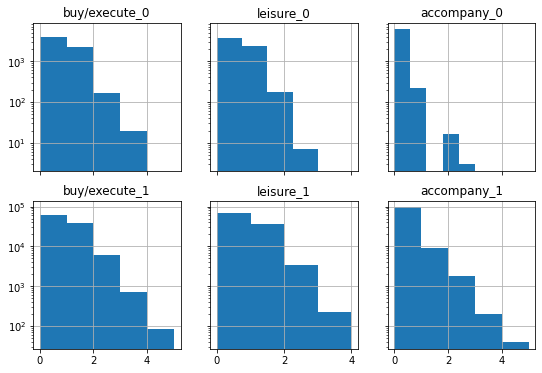

In [23]:
# Number of trips per demand segment
fig, ax = plt.subplots(nrows=2, ncols=len(purposes), figsize=(len(purposes)*3,6),
                       sharex='col', sharey='row')
for i in range(len(purposes)):
    bins = int(persons[purposes[i]].max())
    for car in [0,1]:
        persons.loc[persons['car_av']==car, purposes[i]].hist(bins=bins, log=True, ax=ax[car,i])
        ax[car,i].set_title(purposes[i]+'_'+str(car))

## Build a choice model

Choice variable is the number of trips. The model is segmented in
* population segments: car availability in household
* trip purposes

$V=ASC_0+log(\text{pop})*\beta^{pop}+\text{hh size}*\beta^{size}+\text{hh income}*\beta^{in}+\text{is working}*\beta^{work}+\text{is learning}*\beta^{learn}+\text{is caring}*\beta^{care}+\text{pt ticket}*\beta^{ticket}$

In [25]:
# Result containers
betas = pd.DataFrame()
t_tests = pd.DataFrame()
general = pd.DataFrame()
# Save utility functions for later
Vs = {}

# Number of choices = max_trips-1 (because of 0 trips)
max_trips = 6

car_names = {0: '_no_car', 1: '_car'}
for car in [0,1]:
    # create a database for this population segment
    database = db.Database(car_names[car][1:],
                           persons.loc[persons['car_av']==car].drop('origin', axis=1).copy())
    globals().update(database.variables)
    Vs[car] = {}
    
    # Define parameters
    for p in purposes:
        ASC = {0: ex.Beta('ASC_0', 0, None, None, 0)} # The only free one
        ASC.update({j: ex.Beta('ASC_'+str(j), 0, None, None, 1) for j in range(1, max_trips)})
        b_pop = {j: ex.Beta('b_pop_'+str(j), 0, None, None, 0) for j in range(max_trips)}
        b_size = {j: ex.Beta('b_size_'+str(j), 0, None, None, 0) for j in range(max_trips)}
        b_in = {j: ex.Beta('b_in_'+str(j), 0, None, None, 0) for j in range(max_trips)}
        b_work = {j: ex.Beta('b_work_'+str(j), 0, None, None, 0) for j in range(max_trips)}
        b_learn = {j: ex.Beta('b_learn_'+str(j), 0, None, None, 0) for j in range(max_trips)}
        b_care = {j: ex.Beta('b_care_'+str(j), 0, None, None, 0) for j in range(max_trips)}
        b_ticket = {j: ex.Beta('b_ticket_'+str(j), 0, None, None, 0) for j in range(max_trips)}
        b_acc = {j: ex.Beta('b_acc_'+str(j), 0, None, None, 0) for j in range(max_trips)}
    
    # Define the utility formulation by purpose
    '''Vs[car]['commuting'] = {j:
         ASC[j]
         + ex.log(1+population)*b_pop[j]
         #+ hh_size * b_size[j]
         + hh_income * b_in[j]
         + is_working * b_work[j]
         + pt_ticket * b_ticket[j]
         + acc_commuting * b_acc[j]
         for j in range(max_trips)}
    Vs[car]['business'] = {j:
         ASC[j]
         + ex.log(1+population)*b_pop[j]
         + hh_size * b_size[j]
         + hh_income * b_in[j]
         + is_working * b_work[j]
         + is_learning * b_learn[j]
         + is_caring * b_care[j]
         + pt_ticket * b_ticket[j]
         + acc_business * b_acc[j]
         for j in range(max_trips)}
    Vs[car]['education'] = {j:
         ASC[j]
         + ex.log(1+population)*b_pop[j]
         + hh_size * b_size[j]
         + hh_income * b_in[j]
         + is_learning * b_learn[j]
         + pt_ticket * b_ticket[j]
         + acc_education * b_acc[j]
         for j in range(max_trips)}'''
    Vs[car]['buy/execute'] = {j:
         ASC[j]
         + ex.log(1+population)*b_pop[j]
         + hh_size * b_size[j]
         + hh_income * b_in[j]
         #+ is_working * b_work[j]
         #+ is_learning * b_learn[j]
         #+ is_caring * b_care[j]
         #+ pt_ticket * b_ticket[j]
         + globals()['acc_buy/execute'] * b_acc[j]
         for j in range(max_trips)}
    Vs[car]['leisure'] = {j:
         ASC[j]
         + ex.log(1+population)*b_pop[j]
         + hh_size * b_size[j]
         + hh_income * b_in[j]
         + is_working * b_work[j]
         + is_learning * b_learn[j]
         + is_caring * b_care[j]
         #+ pt_ticket * b_ticket[j]
         + acc_leisure * b_acc[j]
         for j in range(max_trips)}
    Vs[car]['accompany'] = {j:
         ASC[j]
         + ex.log(1+population)*b_pop[j]
         + hh_size * b_size[j]
         + hh_income * b_in[j]
         + is_learning * b_learn[j]
         + is_caring * b_care[j]
         + pt_ticket * b_ticket[j]
         + acc_accompany * b_acc[j]
         for j in range(max_trips)}

    for p in purposes:
        # Remove observations with more trips than the maximum
        database.remove(globals()[p] >= max_trips)
        
        # Run the estimation
        logprob = models.loglogit(Vs[car][p], None, globals()[p])
        formulas = {'loglike': logprob, 'weight': weight} # give weights to the estimator
        model = bio.BIOGEME(database, formulas, numberOfThreads=4)
        model.modelName = p + car_names[car]
        model.generate_html = False
        model.generate_pickle = False
        model.saveIterations = False
        results = model.estimate()
        betas[model.modelName] = results.getEstimatedParameters()['Value']
        t_tests[model.modelName] = np.abs(results.getEstimatedParameters()['Rob. t-test'])

In [ ]:
# Save betas
betas.to_csv(input_path + 'generation_betas.csv')
t_tests.to_csv(input_path + 'generation_t_tests.csv')

In [30]:
# Save aggregated base year variables
persons['zone_agg'] = persons['origin'].astype(str).str[:5]
base_data = persons.groupby(['urbanisation', 'zone_agg']).agg(
    {col: 'mean' for col in ['hh_size', 'hh_income', 'is_working', 'is_learning', 'is_caring', 'pt_ticket']})
# Add population
sm.zones['zone_agg'] = sm.zones['FID'].astype(str).str[:5]
base_data['population'] = sm.zones.groupby(['urbanisation', 'zone_agg'])['population'].sum()
base_data.to_csv(input_path + 'generation_base_data.csv')